### Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import utils
import plotly.graph_objs as go
import dash
from dash import dcc
from dash import html
import plots
from dash.dependencies import Input, Output
from dateutil import parser
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Parsing the Columns

In [6]:
name = 'tech'
bottom_channels = pd.read_csv(f"./{name}/bottom_{name}_vid.csv", index_col = 0)
bottom_channels = utils.parse_cols(bottom_channels)


top_channels = pd.read_csv(f"./{name}/top_{name}_vid.csv", index_col = 0)
top_channels = utils.parse_cols(top_channels)
# Autos: 2 reject
# Shows: 1st only reject
# Travel: 2 reject
# Sports: 1st only reject
# Tech:

Total rows before parsing: 7363
Parser dropped 2 rows during 'publishedAt' parsing


/home/yuvi_dh/side_projects/Projects/smr_yt/eda_nbs/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['publishDayName'] = df['publishedAt'].apply(lambda x: x.strftime("%A"))
/home/yuvi_dh/side_projects/Projects/smr_yt/eda_nbs/utils.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['publishedAt'] = pd.to_datetime(df['publishedAt'])
/home/yuvi_dh/side_projects/Projects/smr_yt/eda_nbs/utils.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

Parser dropped 1 rows during 'viewCount' parsing
Total rows after parsing: 7358
Total rows before parsing: 5410
Parser dropped 0 rows during 'publishedAt' parsing
Parser dropped 0 rows during 'viewCount' parsing
Total rows after parsing: 5407


In [ ]:
# Print rows where 'viewCount' is 0
zero_viewcount_rows = bottom_channels[bottom_channels['viewCount'] == 0]
print("Rows with 'viewCount' as 0:")
print(zero_viewcount_rows.shape)

### Describing the Data

In [7]:
bottom_channels.shape, top_channels.shape

((7358, 20), (5407, 20))

In [ ]:
# print(top_channels.describe(percentiles = [.25, .5, .75, .9, .95, .99]))
# print(bottom_channels.describe(percentiles = [.25, .5, .75, .9, .95, .99]))

### Adding the popularity Column and combining the popular and unpopular dataframes

In [8]:
bottom_channels = utils.add_pop_unpop_col(bottom_channels, False)
top_channels = utils.add_pop_unpop_col(top_channels, True)

In [9]:
comb_vids = utils.combine_pop_unpop_df(top_channels, bottom_channels)

### Removing the Outliers of the Data

In [10]:
# Remove outliers from the dataframe
cleaned_dataframe = utils.remove_outliers(comb_vids)
print(comb_vids.shape, cleaned_dataframe.shape)

(12765, 21) (11179, 21)


### Splitting the columns into 2 Chunks each having popular and unpopular channels on the base of mean of views

In [ ]:
# chunklow_ch_names, chunkhigh_ch_names = utils.split_and_merge_by_views(comb_autos_info)
# chunklow_ch_names.channelName.tolist(), chunkhigh_ch_names.channelName.tolist()

In [11]:
summed_views_df, mean_views_popular, mean_views_unpopular, popular_below_mean, popular_above_mean, unpopular_below_mean, unpopular_above_mean = utils.pop_unpop_chunks(cleaned_dataframe)

above_mean_chunk = popular_above_mean + unpopular_above_mean
below_mean_chunk = popular_below_mean + unpopular_below_mean


print("Mean views of popular channels: ", mean_views_popular)
print("Mean views of unpopular channels: ", mean_views_unpopular)

print(f"Popular channel names with views above mean: {(popular_above_mean)}")
print(f"Popular channel names with views below mean: {(popular_below_mean)}")
print(f"UnPopular channel names with views above mean: {(unpopular_above_mean)}")
print(f"UnPopular channel names with views above mean: {(unpopular_below_mean)}")

Mean views of popular channels:  365745606.5
Mean views of unpopular channels:  25762607.2
Popular channel names with views above mean: ['AWE me', 'ElectroBOOM', 'MONEY TALKS WIRELESS', 'Tech Boss', 'TheBackyardScientist']
Popular channel names with views below mean: ['Fireship', 'MinuteEarth', 'My Primary Solution', 'Naked Science', 'Rare Earth']
UnPopular channel names with views above mean: ['Google Deutschland', 'SamsungChile', 'Tinker Man Mick', 'Uncle Jessy']
UnPopular channel names with views above mean: ['ACCIONA', 'Discovery Canada', 'Make it Extreme Shorts', 'MrEngineer', 'New Scientist', 'Tech & Design']


In [ ]:
# # Run the first App to see the growth of views over the years for above mean chunk
# app = plots.dynamic_view_plots(cleaned_dataframe)
# app.run_server(debug=True, use_reloader=False, mode="inline", port=23000)

In [ ]:
# percentiles = ['.25', '.5', '.75', '.9', '.95', '.99']
# app_2 = plots.percentiles_plot(cleaned_dataframe, percentiles=percentiles)
# app_2.run_server(debug=True, use_reloader=False, mode="inline", port=23001)

/home/yuvi_dh/downloads/installed/miniconda3/envs/data_analysis_env/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


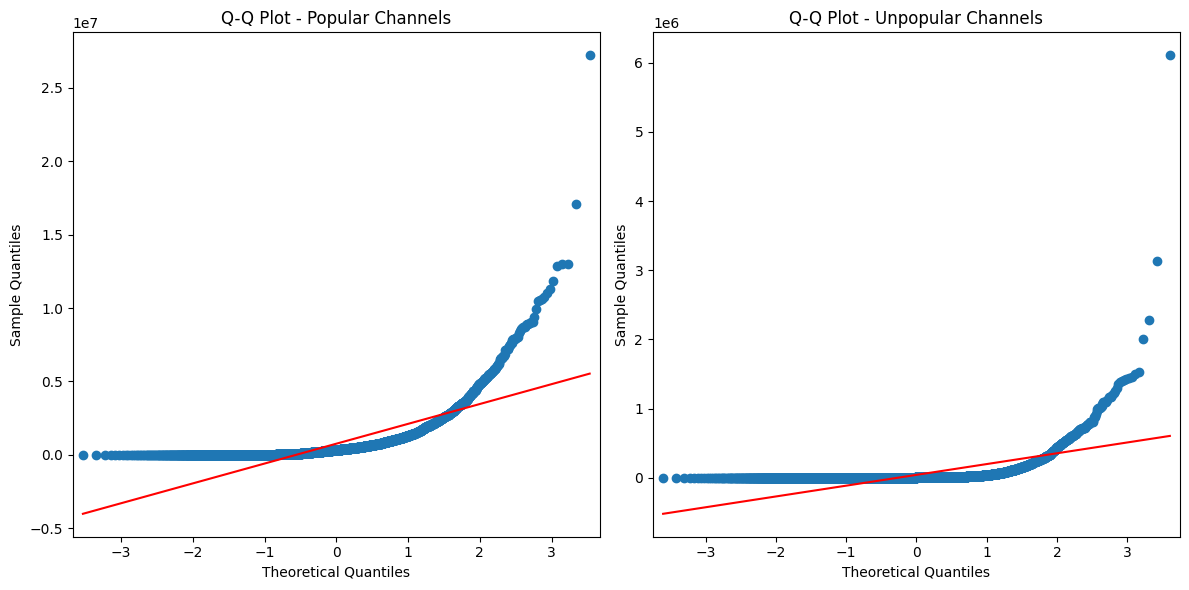

In [12]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

df = cleaned_dataframe
# recent_years = df['publishingYear'].isin([2023, 2022,2021])
# df = df[recent_years]

# Assuming your DataFrame is named 'df'
# Separate data for popular and unpopular channels
popular_views = df[df['pop_unpop'] == 1]['viewCount']
unpopular_views = df[df['pop_unpop'] == 0]['viewCount']

# Create Q-Q plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sm.qqplot(popular_views, line='s', color='blue', ax=axs[0])
axs[0].set_title('Q-Q Plot - Popular Channels')

sm.qqplot(unpopular_views, line='s', color='orange', ax=axs[1])
axs[1].set_title('Q-Q Plot - Unpopular Channels')

plt.tight_layout()
plt.show()

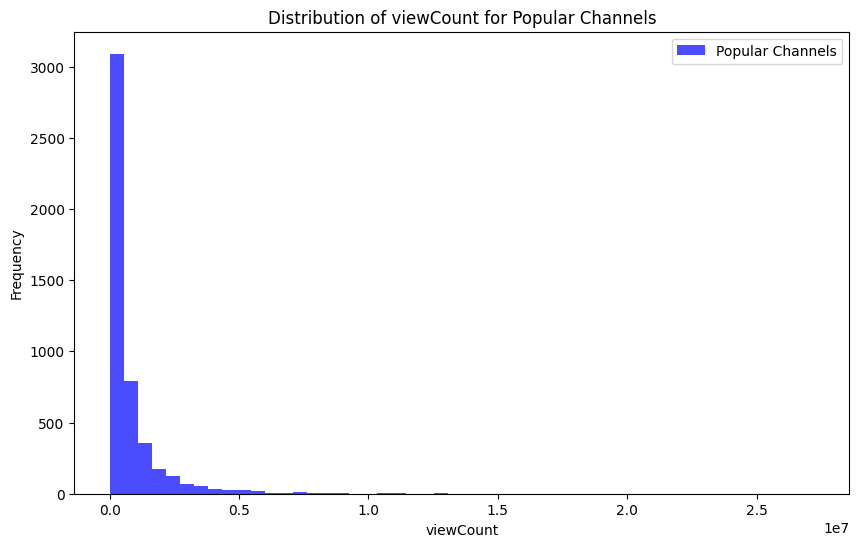

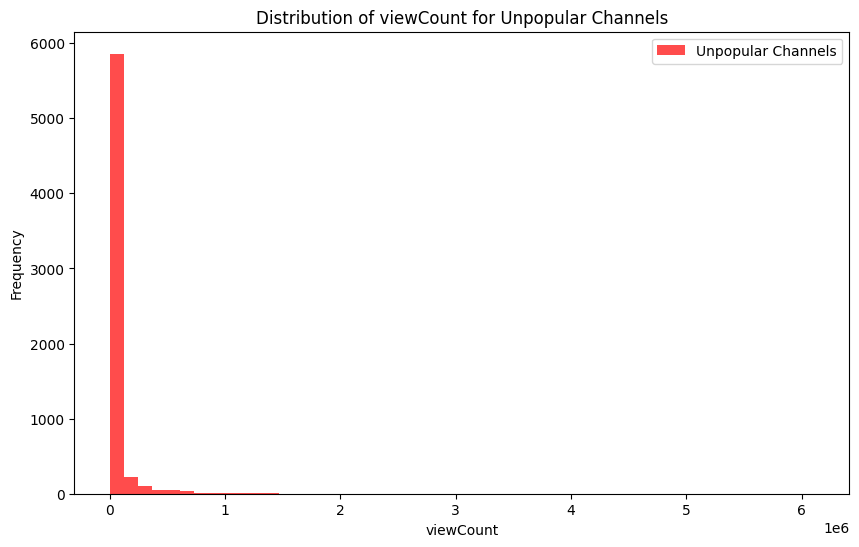

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your CSV file is named 'your_file.csv'
df = cleaned_dataframe

# Separate data for popular and unpopular channels
popular_df = df[df['pop_unpop'] == 1]
unpopular_df = df[df['pop_unpop'] == 0]

# Plotting the distribution of viewCount for popular channels
plt.figure(figsize=(10, 6))
plt.hist(popular_df['viewCount'], bins=50, color='blue', alpha=0.7, label='Popular Channels')
plt.title('Distribution of viewCount for Popular Channels')
plt.xlabel('viewCount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plotting the distribution of viewCount for unpopular channels
plt.figure(figsize=(10, 6))
plt.hist(unpopular_df['viewCount'], bins=50, color='red', alpha=0.7, label='Unpopular Channels')
plt.title('Distribution of viewCount for Unpopular Channels')
plt.xlabel('viewCount')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [15]:
# Assuming your DataFrame is named 'df'
# Filter data for the most recent three years
df = cleaned_dataframe
recent_years = df['publishingYear'].isin([2023, 2022,2021])  # Replace 'year1', 'year2', 'year3' with actual years
filtered_df = df[recent_years]

# Separate data for popular and unpopular channels in the recent years
popular = filtered_df[filtered_df['pop_unpop'] == 1]['viewCount']
unpopular = filtered_df[filtered_df['pop_unpop'] == 0]['viewCount']

# Perform two-tailed t-test
t_statistic, p_value = mannwhitneyu(popular, unpopular)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the view counts of popular and unpopular channels in the recent three years.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the view counts of popular and unpopular channels in the recent three years.")


T-statistic: 8625557.0
P-value: 0.0
Reject the null hypothesis: There is a significant difference between the view counts of popular and unpopular channels in the recent three years.


In [16]:
# Assuming your DataFrame is named 'cleaned_dataframe'
# Filter data for the most recent three years
df = cleaned_dataframe

popular_df = df[df['pop_unpop']==1]
unpopular_df = df[df['pop_unpop']==0]

# Group by channelTitle and calculate the mean view count for each channel
popular_mean_view = popular_df.groupby('channelTitle')['viewCount'].mean().reset_index()
popular_mean_view['pop_unpop'] = 1
unpopular_mean_view = unpopular_df.groupby('channelTitle')['viewCount'].mean().reset_index()
unpopular_mean_view['pop_unpop'] = 0

# Get the view Count
popular = popular_mean_view['viewCount']
unpopular = unpopular_mean_view['viewCount']

# Perform two-tailed t-test
t_statistic, p_value = mannwhitneyu(popular, unpopular)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.01  # Set your significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the mean view counts of popular and unpopular channels.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the mean view counts of popular and unpopular channels.")

T-statistic: 92.0
P-value: 0.0017062493689195964
Reject the null hypothesis: There is a significant difference between the mean view counts of popular and unpopular channels.


In [17]:
popular_mean_view

,channelTitle,viewCount,pop_unpop
0,AWE me,1.905333e+06,1
1,ElectroBOOM,2.411803e+06,1
2,Fireship,4.826832e+05,1
3,MONEY TALKS WIRELESS,4.317788e+05,1
4,MinuteEarth,9.821339e+05,1
5,My Primary Solution,1.463597e+04,1
6,Naked Science,3.672574e+05,1
7,Rare Earth,2.025853e+05,1
8,Tech Boss,7.733842e+05,1
9,TheBackyardScientist,3.108872e+06,1


In [18]:
unpopular_mean_view

,channelTitle,viewCount,pop_unpop
0,ACCIONA,25908.622142,0
1,Discovery Canada,6692.067644,0
2,Google Deutschland,104508.016317,0
3,Make it Extreme Shorts,68236.503448,0
4,MrEngineer,44253.503521,0
5,New Scientist,4338.838488,0
6,SamsungChile,44606.020631,0
7,Tech & Design,126.913621,0
8,Tinker Man Mick,273814.944805,0
9,Uncle Jessy,38535.606061,0
